<font size="10">Learning Global Linearizing Transformations with Koopman Eigenfunctions</font>

<font size="4">This notebook employs an autoencoder neural network structure to develop a data-driven method of discovering Koopman eigenfunctions that can be used to linearize the dynamics of a nonlinear system. Precisely, the r-dimensional output of the encoder represents a basis of r eigenfunctions of the associated Koopman operator. The eigenfunctions are then re-combined as a linear combination to build the decoder function, whose outputs constitute the state-space observables. The training process also simultaneously discovers the eigenvalues associated to each Koopman eigenfunction.</font>

<font size="4">The linearization method is applied to the simple two-dimensional nonlinear map 
$f = (f_1,f_2):\mathbb{R}^2 \to \mathbb{R}^2$ whose right-hand-side is given by</font> 
    
$f_1(x_1,x_2) = \lambda_1 x_1,$
    
$f_2(x_1,x_2) = \lambda_2 (x_2 - x_1^2).$
    
<font size="4">For this mapping the linearizing eigenfunctions are known to be the set:</font> 
    
$\psi_1(x_1,x_2) = x_1, \quad  \psi_2(x_1,x_2) = x_2 - \frac{\lambda_2}{\lambda_2 - \lambda_1^2}x_1^2, \quad \psi_3(x_1,x_2) = x_1^2$

    
<font size="4">with corresponding eigenfunctions 
$\mu_1 = \lambda_1$, $\mu_2 = \lambda_2$, and $\mu_3 = \lambda_1^2$, respectively. For a demonstration of these results see the examples in Section 2.3 of the accompanying textbook.</font> 


<font size="4">This code was written by Mohit Sahu and accompanies the work in Section 6.3 of the book. <i>Data-Driven Methods for Dynamic Systems</i>. This script was adapted from the Tensorflow version by Jason J. Bramburger. We use PyTorch 2.3.0 to build the neural network</font>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# 2D nonlinear map for example
def map(x,lam1 = 1.5, lam2 = 0.5):

    xnp1 = [lam1*x[0], lam2*(x[1] - x[0]**2)]

    return xnp1

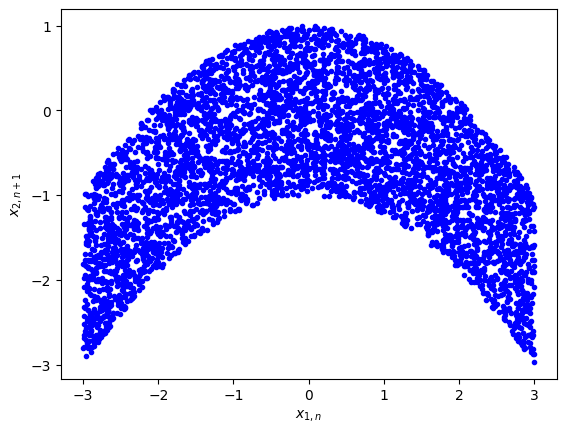

In [ ]:
# Sample random points in the domain [-1,1]^2 and determine their image under map in previious block

# Initializations
N = 5000 # number of samples
# Map parameters
lam1 = 1.5
lam2 = 0.5

xn = 4*np.random.rand(2,N) - 2
xnp1 = np.array(map(xn, lam1, lam2)).T
xn = xn.T

# Plot the image of the unit square under the map for visualization
plt.plot(xnp1[:,0],xnp1[:,1],'b.')
plt.xlabel('$x_{1,n}$',)
plt.ylabel('$x_{2,n+1}$')
plt.rc('font', size= 16)

In [ ]:
# Conjugacy neural network architecture

class Conjugacy(nn.Module):
    def __init__(self,
                 width = 100,
                 size_x = 2,
                 size_y = 3,
                 activation = nn.SELU(),
                 numblksIn = 1,
                 l1reg = 1e-15,
                 l2reg = 1e-15,
                 **kwargs):
        super(Conjugacy, self).__init__()
        self.width = width
        self.size_x = size_x
        self.size_y = size_y
        self.activation = activation
        self.numblksIn = numblksIn
        self.l1reg = l1reg
        self.l2reg = l2reg

        # Real-valued Koopman eigenvalues
        self.a1 = nn.Parameter(torch.tensor(1.5,requires_grad=True))
        self.a2 = nn.Parameter(torch.tensor(0.5,requires_grad=True))
        self.a3 = nn.Parameter(torch.tensor(2.25,requires_grad=True))

        # Encoder function
        encoder_layers = [nn.Linear(self.size_x, self.width), self.activation]
        for _ in range(self.numblksIn-1):  # adding more layers
            encoder_layers.append(nn.Linear(self.width, self.width))
            encoder_layers.append(self.activation)

        # Final layer to go to Koopman observables
        encoder_layers.append(nn.Linear(self.width, size_y))
        encoder_layers.append(self.activation)
        self.encoder = nn.Sequential(*encoder_layers)

        # Decoder Function: single layer linear output
        self.decoder = nn.Linear(size_y, self.size_x, self.activation)

        # Initialize weights in the model
        self.apply(self._initialize_weight)

    def _initialize_weight(self, module):
        if isinstance(module, nn.Linear):
            # apply a normal distribution to the weights and bias
            nn.init.normal_(module.weight, mean=0, std=0.1)
            nn.init.normal_(module.bias, mean=0, std=0.1)

    def forward(self, x):
        encoded = self.encoder(x)

        # Build foward iterates under linear map
        y1np1 = self.a1*encoded[:,0]
        y2np1 = self.a2*encoded[:,1]
        y3np1 = self.a3*encoded[:,2]

        # Stack forward iterates of linear map back together
        encoded_p1 = torch.stack([y1np1, y2np1, y3np1], dim=1)
        decoded = self.decoder(encoded_p1)

        # Encoder/Decoder loss
        x_recon = self.decoder(encoded)
        conjugacy_loss = torch.mean(torch.square(x - x_recon))

        # f = rho of g of eta loss
        xnp1_1 = lam1*x[:,0]
        xnp1_2 = lam2*(x[:,1] - torch.square(x[:,0]))
        xnp1 = torch.stack([xnp1_1, xnp1_2], dim=1)
        prediction_loss = torch.mean(torch.square(decoded - xnp1))

        # Linear map (g) loss
        xnp1_encoded = self.encoder(xnp1)
        g_loss = torch.mean(torch.square(encoded_p1 - xnp1_encoded))

        # L1L2 Regularization loss
        L1L2_loss = sum(self.l1reg*p.abs().sum() for p in self.encoder.parameters()) + self.l1reg*sum(p.abs().sum() for p in self.decoder.parameters())  # L1 Loss
        L1L2_loss += sum(self.l2reg*p.pow(2).sum() for p in self.encoder.parameters()) + self.l2reg*sum(p.pow(2).sum() for p in self.decoder.parameters())  # L2 Loss

        total_loss = conjugacy_loss + prediction_loss + g_loss + L1L2_loss

        return decoded, total_loss

In [ ]:
# Neural Network Parameters

width = 200 # width of each NN layer
size_x = 2 # number of variables in the original nonlinear map
size_y = 3 # number of variables in the linear Koopman map
activation = nn.SELU() # nonlinear activation function at each NN layer of the encoder
learning_rate = 0.00005
numblks_in = 6 # number of layers for the encoder NN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
conjugacy = Conjugacy(width, size_x, size_y, activation, numblks_in).to(device)

optimizer = optim.Adam(conjugacy.parameters(), lr=learning_rate)

xn = torch.tensor(xn, dtype=torch.float32, requires_grad=True).to(device)
train_dataloader = DataLoader(xn, batch_size=32)

In [ ]:
def train(model, optimizer, train_dataloader, epochs=10, patience=200):
    model.train()
    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        for xt in train_dataloader:
            optimizer.zero_grad()
            decoded, loss = model(xt)
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

        if loss.item() < best_loss:
            best_loss = loss.item()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

train(conjugacy, optimizer, train_dataloader, epochs=10)

Epoch 1/10, Loss: 0.9724535346031189
Epoch 2/10, Loss: 0.7552564144134521
Epoch 3/10, Loss: 0.6642003059387207
Epoch 4/10, Loss: 0.6079604625701904
Epoch 5/10, Loss: 0.5657325983047485
Epoch 6/10, Loss: 0.5303261280059814
Epoch 7/10, Loss: 0.5010843276977539
Epoch 8/10, Loss: 0.4741849899291992
Epoch 9/10, Loss: 0.45053669810295105
Epoch 10/10, Loss: 0.42842766642570496


In [ ]:
# Print Discovered Eigenvalues
print('Discovered Koopman Eigenvalues (assumed real)')
print('---------------------------------------------')
print('a1 = ', conjugacy.a1.cpu().detach().numpy())
print('a2 = ', conjugacy.a2.cpu().detach().numpy())
print('a3 = ', conjugacy.a3.cpu().detach().numpy())
print('')
print('True Koopman Eigenvalues')
print('------------------------')
print('a1 = ', lam1)
print('a2 = ', lam2)
print('a3 = ', lam1**2)
print('')
print('NOTE: Discovered eigenvalues may appear in a different order from the true values')

print('')
print('Weights of the linear layer')
print('------------------------')
linear_weights = conjugacy.decoder.weight.cpu().detach()
print(linear_weights)

Discovered Koopman Eigenvalues (assumed real)
---------------------------------------------
a1 =  1.4651532
a2 =  0.49480328
a3 =  2.1897073

True Koopman Eigenvalues
------------------------
a1 =  1.5
a2 =  0.5
a3 =  2.25

NOTE: Discovered eigenvalues may appear in a different order from the true values

Weights of the linear layer
------------------------
tensor([[-0.9097, -0.0860, -0.1818],
        [ 0.1567,  0.3937,  0.3954]])


<font size="6">**Another Network Architecture**</font>

<font size="4">The code that follows trains an autoencoder network to discover both the real and imaginary parts of the eigenvalues/eigenvectors. Since the true eigenvalues/eigenvectors are real, we should expect the imaginary parts to all be zero.</font>

<font size="4">Saved model used to produce the results in the text is in the `saved_conjugacy_networks' folder under the name 'global_linear_complex'.</font>

In [ ]:
# Conjugacy neural network architecture

class Conjugacy(nn.Module):
    def __init__(self,
                 width = 100,
                 size_x = 2,
                 size_y = 6,
                 activation = nn.SELU(),
                 numblksIn = 1,
                 l1reg = 1e-15,
                 l2reg = 1e-15,
                 **kwargs):
        super(Conjugacy, self).__init__()
        self.width = width
        self.size_x = size_x
        self.size_y = size_y
        self.activation = activation
        self.numblksIn = numblksIn
        self.l1reg = l1reg
        self.l2reg = l2reg

        # Real-valued Koopman eigenvalues
        self.a1 = nn.Parameter(torch.tensor(1.5,requires_grad=True))
        self.a2 = nn.Parameter(torch.tensor(0.5,requires_grad=True))
        self.a3 = nn.Parameter(torch.tensor(2.25,requires_grad=True))
        self.b1 = nn.Parameter(torch.tensor(0.0,requires_grad=True))
        self.b2 = nn.Parameter(torch.tensor(0.0,requires_grad=True))
        self.b3 = nn.Parameter(torch.tensor(0.0,requires_grad=True))

        # Encoder function
        encoder_layers = [nn.Linear(self.size_x, self.width), self.activation]
        for _ in range(self.numblksIn-1):  # adding more layers
            encoder_layers.append(nn.Linear(self.width, self.width))
            encoder_layers.append(self.activation)

        # Final layer to go to Koopman observables
        encoder_layers.append(nn.Linear(self.width, size_y))
        encoder_layers.append(self.activation)
        self.encoder = nn.Sequential(*encoder_layers)

        # Decoder Function: single layer linear output
        self.decoder = nn.Linear(size_y, self.size_x, self.activation)

        # Initialize weights in the model
        self.apply(self._initialize_weight)

    def _initialize_weight(self, module):
        if isinstance(module, nn.Linear):
            # apply a normal distribution to the weights and bias
            nn.init.normal_(module.weight, mean=0, std=0.1)
            nn.init.normal_(module.bias, mean=0, std=0.1)

    def forward(self, x):
        encoded = self.encoder(x)

        # Build foward iterates under linear map
        y1np1 = self.a1*encoded[:,0] + self.b1*encoded[:,1]
        y2np1 = -self.b1*encoded[:,0] + self.a1*encoded[:,1]
        y3np1 = self.a2*encoded[:,2] + self.b2*encoded[:,3]
        y4np1 = -self.b2*encoded[:,2] + self.a2*encoded[:,3]
        y5np1 = self.a3*encoded[:,4] + self.b3*encoded[:,5]
        y6np1 = -self.b3*encoded[:,4] + self.a3*encoded[:,5]

        # Stack forward iterates of linear map back together
        encoded_p1 = torch.stack([y1np1, y2np1, y3np1, y4np1, y5np1, y6np1], dim=1)
        decoded = self.decoder(encoded_p1)

        # Encoder/Decoder loss
        x_recon = self.decoder(encoded)
        conjugacy_loss = torch.mean(torch.square(x - x_recon))

        # f = rho of g of eta loss
        xnp1_1 = lam1*x[:,0]
        xnp1_2 = lam2*(x[:,1] - torch.square(x[:,0]))
        xnp1 = torch.stack([xnp1_1, xnp1_2], dim=1)
        prediction_loss = torch.mean(torch.square(decoded - xnp1))

        # Linear map (g) loss
        xnp1_encoded = self.encoder(xnp1)
        g_loss = torch.mean(torch.square(encoded_p1 - xnp1_encoded))

        # L1L2 Regularization loss
        L1L2_loss = sum(self.l1reg*p.abs().sum() for p in self.encoder.parameters()) + self.l1reg*sum(p.abs().sum() for p in self.decoder.parameters())  # L1 Loss
        L1L2_loss += sum(self.l2reg*p.pow(2).sum() for p in self.encoder.parameters()) + self.l2reg*sum(p.pow(2).sum() for p in self.decoder.parameters())  # L2 Loss

        total_loss = conjugacy_loss + prediction_loss + g_loss + L1L2_loss

        return decoded, total_loss

In [ ]:
# Neural Network Parameters

width = 200 # width of each NN layer
size_x = 2 # number of variables in the original nonlinear map
size_y = 6 # number of variables in the linear Koopman map
activation = nn.SELU() # nonlinear activation function at each NN layer of the encoder
learning_rate = 0.000001
numblks_in = 6 # number of layers for the encoder NN

conjugacy = Conjugacy(width, size_x, size_y, activation, numblks_in).to(device)
optimizer = optim.Adam(conjugacy.parameters(), lr=learning_rate)

xn = torch.tensor(xn, dtype=torch.float32, requires_grad=True).to(device)
train_dataloader = DataLoader(xn, batch_size=32)

<ipython-input-11-3df5e86c31ea>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xn = torch.tensor(xn, dtype=torch.float32, requires_grad=True).to(device)


In [ ]:
train(conjugacy, optimizer, train_dataloader, epochs=10)

Epoch 1/10, Loss: 5.956335544586182
Epoch 2/10, Loss: 3.500112533569336
Epoch 3/10, Loss: 2.190892219543457
Epoch 4/10, Loss: 1.5956292152404785
Epoch 5/10, Loss: 1.2477918863296509
Epoch 6/10, Loss: 1.0581715106964111
Epoch 7/10, Loss: 0.9515830278396606
Epoch 8/10, Loss: 0.889076292514801
Epoch 9/10, Loss: 0.8479383587837219
Epoch 10/10, Loss: 0.8161971569061279


In [ ]:
# Print Discovered Eigenvalues
print('Discovered Koopman Eigenvalues - Real parts')
print('---------------------------------------------')
print('a1 = ', conjugacy.a1.cpu().detach().numpy())
print('a2 = ', conjugacy.a2.cpu().detach().numpy())
print('a3 = ', conjugacy.a3.cpu().detach().numpy())
print('')
print('Discovered Koopman Eigenvalues - Imaginary parts')
print('---------------------------------------------')
print('b1 = ', conjugacy.b1.cpu().detach().numpy())
print('b2 = ', conjugacy.b2.cpu().detach().numpy())
print('b3 = ', conjugacy.b3.cpu().detach().numpy())
print('')
print('NOTE: Discovered eigenvalues may appear in a different order from the true values')

print('')
print('Weights of the linear layer')
print('------------------------')
linear_weights = conjugacy.decoder.weight.cpu().detach()
print(linear_weights)

Discovered Koopman Eigenvalues - Real parts
---------------------------------------------
a1 =  1.4992948
a2 =  0.50098866
a3 =  2.2497041

Discovered Koopman Eigenvalues - Imaginary parts
---------------------------------------------
b1 =  -0.00059682963
b2 =  0.0006623159
b3 =  0.00016648594

NOTE: Discovered eigenvalues may appear in a different order from the true values

Weights of the linear layer
------------------------
tensor([[ 0.3676,  0.1629,  0.2176, -0.3566,  0.6965, -0.1673],
        [ 0.5133, -0.7030, -0.4966, -0.1386, -0.8929, -0.5688]])


In [ ]:
# Loading and view the saved model
import tensorflow as tf

def loadModel(file_path, numblksIn=7):
    tf_model = tf.keras.models.load_model(file_path, compile=False)

    conju_wt = tf_model.get_weights()
    conju_wt = [torch.tensor(cmc, dtype=torch.float32).to(device) for cmc in conju_wt]

    pytorch_model = Conjugacy(size_y=6, numblksIn=numblksIn)
    for i in range(numblksIn+1):
        pytorch_model.encoder[2*i].weight = nn.Parameter(conju_wt[2*i].T)
        pytorch_model.encoder[2*i].bias = nn.Parameter(conju_wt[2*i+1])

    pytorch_model.decoder.weight = nn.Parameter(conju_wt[2*(numblksIn+1)].T)
    pytorch_model.decoder.bias = nn.Parameter(conju_wt[2*(numblksIn+1)+1])

    # load variables
    variables = [
        'pytorch_model.a1 = nn.Parameter(torch.tensor(tf_model.a1.numpy()).to(device))',
        'pytorch_model.a2 = nn.Parameter(torch.tensor(tf_model.a2.numpy()).to(device))',
        'pytorch_model.a3 = nn.Parameter(torch.tensor(tf_model.a3.numpy()).to(device))',
        'pytorch_model.b1 = nn.Parameter(torch.tensor(tf_model.b1.numpy()).to(device))',
        'pytorch_model.b2 = nn.Parameter(torch.tensor(tf_model.b2.numpy()).to(device))',
        'pytorch_model.b3 = nn.Parameter(torch.tensor(tf_model.b3.numpy()).to(device))',
    ]

    for line in variables:
        try:
            exec(line)
        except Exception as e:
            pass

    return pytorch_model

conjugacy = loadModel("../saved_conjugacy_networks/global_linear_complex")

c:\Users\mohit\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [ ]:
# Print Discovered Eigenvalues
print('Discovered Koopman Eigenvalues - Real parts')
print('---------------------------------------------')
print('a1 = ', conjugacy.a1.cpu().detach().numpy())
print('a2 = ', conjugacy.a2.cpu().detach().numpy())
print('a3 = ', conjugacy.a3.cpu().detach().numpy())
print('')
print('Discovered Koopman Eigenvalues - Imaginary parts')
print('---------------------------------------------')
print('b1 = ', conjugacy.b1.cpu().detach().numpy())
print('b2 = ', conjugacy.b2.cpu().detach().numpy())
print('b3 = ', conjugacy.b3.cpu().detach().numpy())
print('')
print('NOTE: Discovered eigenvalues may appear in a different order from the true values')

print('')
print('Weights of the linear layer')
print('------------------------')
linear_weights = conjugacy.decoder.weight.cpu().detach()
print(linear_weights)

Discovered Koopman Eigenvalues - Real parts
---------------------------------------------
a1 =  1.4990752
a2 =  0.49936298
a3 =  2.2649937

Discovered Koopman Eigenvalues - Imaginary parts
---------------------------------------------
b1 =  -0.0057560285
b2 =  0.0012338609
b3 =  0.01593717

NOTE: Discovered eigenvalues may appear in a different order from the true values

Weights of the linear layer
------------------------
tensor(0.4994)
